# VQSVD en PennyLane - Implementación Completa

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import numpy as onp

## Configuración y Ansatz

In [2]:
n_qubits = 2
depth = 2
rank = 2
dev = qml.device("default.qubit", wires=n_qubits)

def ansatz(params, wires):
    for d in range(params.shape[0]):
        for i in range(len(wires)):
            qml.RY(params[d, i, 0], wires=wires[i])
            qml.RZ(params[d, i, 1], wires=wires[i])
        for i in range(len(wires) - 1):
            qml.CNOT(wires=[wires[i], wires[i+1]])

## QNode y Función de Pérdida

In [3]:
@qml.qnode(dev)
def vqsvd_expectation(theta, phi, i, M):
    bin_i = format(i, f"0{n_qubits}b")
    for j, bit in enumerate(reversed(bin_i)):
        if bit == "1":
            qml.PauliX(wires=j)
    ansatz(phi, wires=range(n_qubits))
    qml.Hermitian(M, wires=range(n_qubits))
    qml.adjoint(ansatz)(theta, wires=range(n_qubits))
    return qml.expval(qml.Projector([int(b) for b in reversed(bin_i)], wires=range(n_qubits)))

def vqsvd_loss(theta, phi, M, rank, weights):
    loss = 0.0
    singular_values = []
    for i in range(rank):
        val = np.real(vqsvd_expectation(theta, phi, i, M))
        singular_values.append(val)
        loss -= weights[i] * val
    return loss, np.array(singular_values)

## Entrenamiento

In [4]:
def train_vqsvd(M, rank=2, depth=2, steps=100, lr=0.1):
    theta = np.random.uniform(0, 2*np.pi, (depth, n_qubits, 2), requires_grad=True)
    phi = np.random.uniform(0, 2*np.pi, (depth, n_qubits, 2), requires_grad=True)
    weights = np.arange(rank * 3, 0, -3).astype(float)
    opt = qml.AdamOptimizer(lr)
    losses, svals = [], []
    for step in range(steps):
        (theta, phi), _ = opt.step_and_cost(lambda t, p: vqsvd_loss(t, p, M, rank, weights)[0], theta, phi)
        loss, s = vqsvd_loss(theta, phi, M, rank, weights)
        losses.append(loss)
        svals.append(s)
        if step % 10 == 0:
            print(f"Step {step}: Loss = {loss:.4f}, Singular values = {s}")
    return theta, phi, losses, svals

## Funciones auxiliares para evaluación y visualización

In [5]:
def get_unitary_matrix(ansatz_fn, params):
    n_qubits = params.shape[1]
    dev_tmp = qml.device("default.qubit", wires=n_qubits)
    basis_states = [format(i, f"0{n_qubits}b") for i in range(2**n_qubits)]
    matrix_columns = []
    @qml.qnode(dev_tmp)
    def basis_circuit(state_bin, params):
        for j, bit in enumerate(reversed(state_bin)):
            if bit == "1":
                qml.PauliX(wires=j)
        ansatz_fn(params, wires=range(n_qubits))
        return qml.state()
    for b in basis_states:
        final_state = basis_circuit(b, params)
        matrix_columns.append(final_state)
    return np.column_stack(matrix_columns)

def frobenius_error(M, U, S, V_dagger):
    M_reconst = U @ np.diag(S) @ V_dagger
    return onp.linalg.norm(M - M_reconst)

def plot_loss_curve(losses):
    plt.plot(range(len(losses)), losses)
    plt.xlabel("Iteración")
    plt.ylabel("Pérdida")
    plt.title("Curva de pérdida del entrenamiento VQSVD")
    plt.grid(True)
    plt.show()

def plot_singular_values_comparison(M, learned_singular_values):
    _, true_svals, _ = onp.linalg.svd(M)
    plt.plot(true_svals[:len(learned_singular_values)], 'o-', label="SVD real")
    plt.plot(learned_singular_values, 's--', label="VQSVD aprendido")
    plt.xlabel("Índice")
    plt.ylabel("Valor singular")
    plt.title("Comparación de valores singulares")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_matrix_as_image(M, title="Reconstrucción"):
    plt.imshow(onp.real(M), cmap="gray")
    plt.title(title)
    plt.colorbar()
    plt.show()

## Ejecución completa

## Ejecución completa con corrección de reconstrucción

Step 0: Loss = -6.1850, Singular values = [0.68196934 0.69774145]
Step 10: Loss = -8.7005, Singular values = [0.96589864 0.9683641 ]
Step 20: Loss = -8.8939, Singular values = [0.99225409 0.98011894]
Step 30: Loss = -8.9525, Singular values = [0.99451981 0.99512746]
Step 40: Loss = -8.9934, Singular values = [0.9993601  0.99907909]
Step 50: Loss = -8.9977, Singular values = [0.99973912 0.99974977]
Step 60: Loss = -8.9983, Singular values = [0.99985868 0.99970816]
Step 70: Loss = -8.9997, Singular values = [0.99997232 0.9999661 ]
Step 80: Loss = -8.9998, Singular values = [0.99998082 0.99997713]
Step 90: Loss = -8.9999, Singular values = [0.99999249 0.99997881]


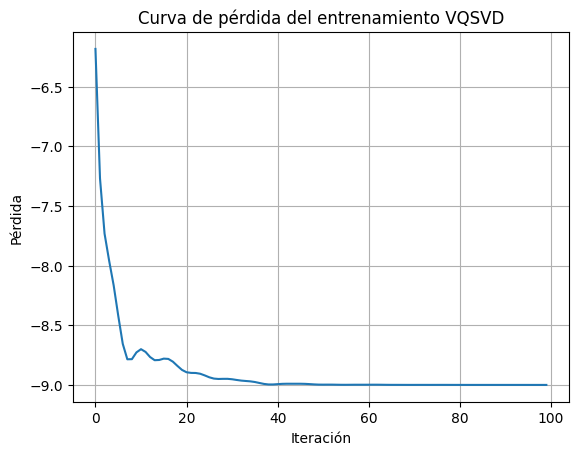

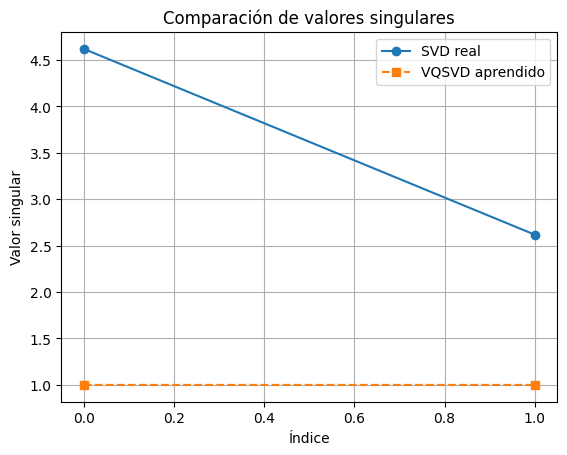

Error Frobenius: 5.992756459195413


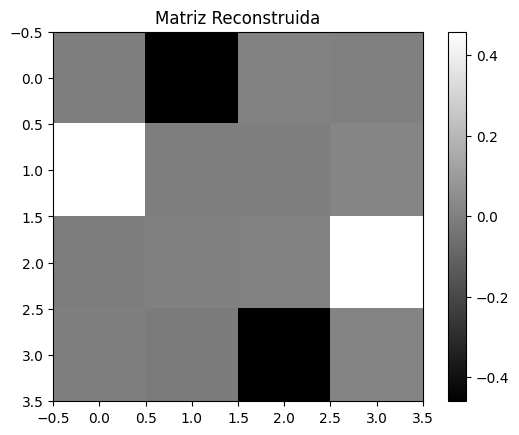

In [6]:
M_test = np.array([[1, 1, 0, 0],
                   [1, 2, 0, 0],
                   [0, 0, 3, 1],
                   [0, 0, 1, 4]])

theta_trained, phi_trained, loss_history, svals_history = train_vqsvd(M_test)
plot_loss_curve(loss_history)
plot_singular_values_comparison(M_test, svals_history[-1])

U_learned = get_unitary_matrix(ansatz, theta_trained)
V_learned = get_unitary_matrix(ansatz, phi_trained)
V_dagger_learned = onp.conj(V_learned.T)
S_learned = svals_history[-1]

# Corregir dimensión de la matriz diagonal
def extend_singular_values(S, full_size):
    D = np.zeros((full_size, full_size))
    for i in range(len(S)):
        D[i, i] = S[i]
    return D

D_extended = extend_singular_values(S_learned, U_learned.shape[0])
M_approx = U_learned @ D_extended @ V_dagger_learned
error = onp.linalg.norm(M_test - M_approx)
print("Error Frobenius:", error)

plot_matrix_as_image(M_approx, title="Matriz Reconstruida")